## Import

In [1]:
%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# from __future__ import print_function

from keras.utils import pad_sequences
from keras.datasets import imdb
from keras.layers import Dense, LSTM, Dropout, Embedding, Input, Conv1D, Reshape, Flatten, Lambda
from keras.models import Model, Sequential
from keras.callbacks import EarlyStopping
from keras.optimizers import Adam
from keras import backend as K
from kerasapp.keras import plot_acc, plot_loss

from sklearn.model_selection import train_test_split

## Binary classfication LSTM(IMDB 긍부정)

In [51]:
class Data:
    """
    max_features = 문장을 세어봤을 때 20000위까지(단어 토큰 개수)
    maxlen = 문장 최대 길이
    """
    def __init__(self, max_features=20000, maxlen=80):
        (self.x_train, self.y_train), (self.x_test, self.y_test) =\
                                    imdb.load_data(num_words=max_features)
        self.x_train = pad_sequences(self.x_train, maxlen=maxlen) # 80 이상을 잘라내거나 모자란 부분은 padding으로 채움
        self.x_test = pad_sequences(self.x_test, maxlen=maxlen)

In [52]:
class RNN_LSTM(Model):
    def __init__(self, max_features, maxlen):
        x = Input((maxlen, ))
        h = Embedding(max_features, 128)(x)
        h = LSTM(128, dropout=0.2, recurrent_dropout=0.2)(h)
        y = Dense(1, activation='relu')(h)
        super().__init__(x, y)
        
        
        self.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [53]:
class Machine:
    def __init__(self, max_features=20000, maxlen=300):
        self.data = Data(max_features, maxlen)
        self.model = RNN_LSTM(max_features, maxlen)
        
    def run(self, epochs=3, batch_size=32):
        data = self.data
        model = self.model
        print('Training stage')
        print("==============")
        
        early_stopping = EarlyStopping(monitor='val_loss', patience=3)
        
        model.fit(data.x_train, data.y_train, batch_size=batch_size, epochs=epochs, \
                    validation_data = (data.x_test, data.y_test), callbacks=[early_stopping])
        
        score, acc = model.evaluate(data.x_test, data.y_test, batch_size=batch_size)
        print(f"Test performance : accuracy : {acc:.2f}, loss : {score:.2f}")

In [ ]:
m = Machine()
m.run()

In [47]:
print(m.data.x_train[0])

[   15   256     4     2     7  3766     5   723    36    71    43   530
   476    26   400   317    46     7     4 12118  1029    13   104    88
     4   381    15   297    98    32  2071    56    26   141     6   194
  7486    18     4   226    22    21   134   476    26   480     5   144
    30  5535    18    51    36    28   224    92    25   104     4   226
    65    16    38  1334    88    12    16   283     5    16  4472   113
   103    32    15    16  5345    19   178    32]


## LSTM 시계열 데이터 예측

In [38]:
def load_data(fname='international-airline-passengers.csv'):
    dataset = pd.read_csv(fname, usecols=[1], engine='python', skipfooter=3)
    data = dataset.values.reshape(-1)
    plt.plot(data)
    plt.xlabel('Time')
    plt.ylabel('#Passengers')
    plt.title('Original Data')
    plt.show()
    
    data_dn = (data - np.mean(data)) / np.std(data) / 5
    plt.plot(data_dn)
    plt.xlabel('Time')
    plt.ylabel('Normalized #Passengers')
    plt.title('Normalized data by $E[]$ and $5\sigma$')
    plt.show()
    
    return data_dn

def get_Xy(data, D=12):
    X_l = []
    y_l = []
    N = len(data)
    assert N > D, "N should be larger than D, where N is len(data)"
    for ii in range(N-D-1):
        X_l.append(data[ii:ii+D])
        y_l.append(data[ii+D])
    X = np.array(X_l)
    X = X.reshape(X.shape[0], X.shape[1], 1)
    y = np.array(y_l)
    print(X.shape, y.shape)
    return X, y

In [39]:
class Dataset:
    def __init__(self, fname='international-airline-passengers.csv', D=12):
        data_dn = load_data(fname=fname)
        self.X, self.y = get_Xy(data_dn, D=D)
        self.X_train, self.X_test, self.y_train, self.y_test = \
            train_test_split(self.X, self.y, test_size=0.2, random_state=42)

In [40]:
def rnn_model(shape):
    m_x = Input(shape=shape)
    m_h = LSTM(10)(m_x)
    m_y = Dense(1)(m_h)
    m = Model(m_x, m_y)
    m.compile('adam', 'mean_squared_error')
    m.summary()
    return m

In [41]:
class Machine: # ()
    def __init__(self):
        self.data = Dataset()
        shape = self.data.X.shape[1:]
        self.model = rnn_model(shape)
        
    def run(self, epochs=400):
        d = self.data
        X_train, X_test, y_train, y_test = d.X_train, d.X_test, d.y_train, d.y_test
        X, y = d.X, d.y
        m = self.model
        h = m.fit(X_train, y_train, epochs=epochs, validation_data=[X_test, y_test], verbose=0)
        
        plot_loss(h)
        plt.show()
        
        yp = m.predict(X_test)
        print(f'Loss : {m.evaluate(X_test, y_test)}')
        plt.plot(yp, label='Original')
        plt.plot(y_test, label='Prediction')
        plt.legend(loc=0)
        plt.title('Validation Results')
        plt.show()
        
        yp = m.predict(X_test).reshape(-1)
        print(f'Loss : {m.evaluate(X_test, y_test)}')
        print(yp.shape, y_test.shape)
        
        df = pd.DataFrame()
        df['Sample'] = list(range(len(y_test))) * 2
        df['Normalized #Passengers'] = np.concatenate([y_test, yp], axis=0)
        df['Type'] = ['Original'] * len(y_test) + ['prediction'] * len(yp)
        
        plt.figure(figsize=(7,5))
        sns.barplot(x="Sample", y="Normalized #Passengers", hue="Type", data=df)
        plt.ylabel('Normalized #Passengers')
        plt.show()
        
        yp = m.predict(X)
        
        plt.plot(yp, label="Original")
        plt.plot(y, label='Prediction')
        plt.legend(loc=0)
        plt.title('All Results')
        plt.show()
        


In [42]:
def main():
    machine = Machine()
    machine.run(epochs=400)

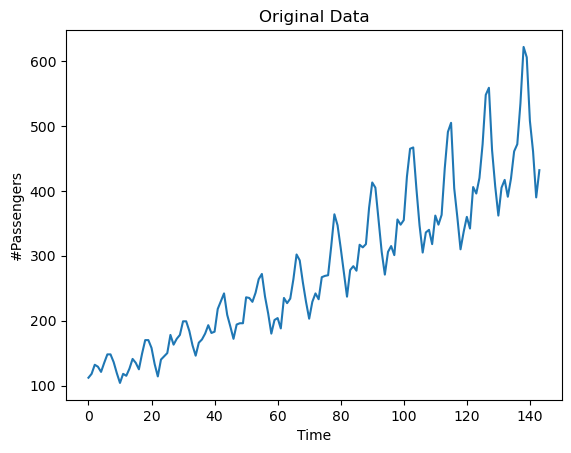

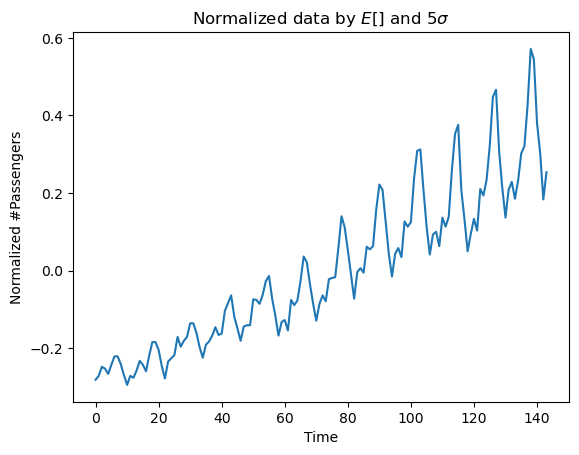

(131, 12, 1) (131,)
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 12, 1)]           0         
                                                                 
 lstm_1 (LSTM)               (None, 10)                480       
                                                                 
 dense_19 (Dense)            (None, 1)                 11        
                                                                 
Total params: 491
Trainable params: 491
Non-trainable params: 0
_________________________________________________________________


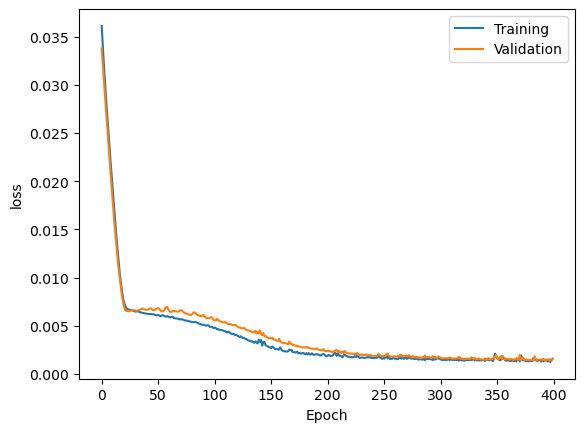

1/1 [==============================] - 0s 19ms/step - loss: 0.0016
Loss : 0.0016061806818470359


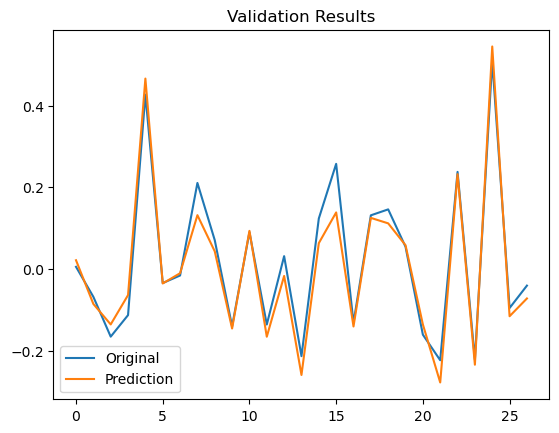

1/1 [==============================] - 0s 18ms/step - loss: 0.0016
Loss : 0.0016061806818470359
(27,) (27,)


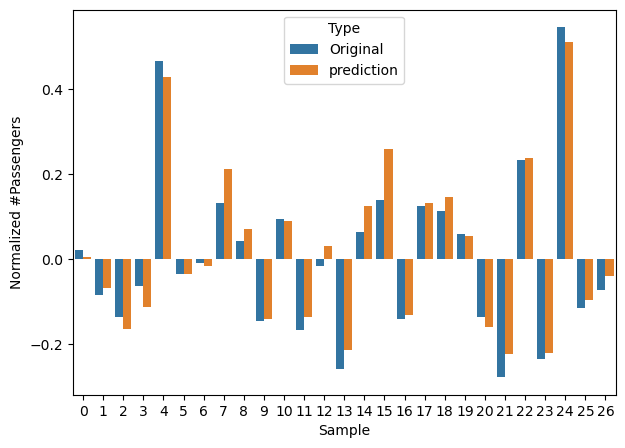

5/5 [==============================] - 0s 2ms/step


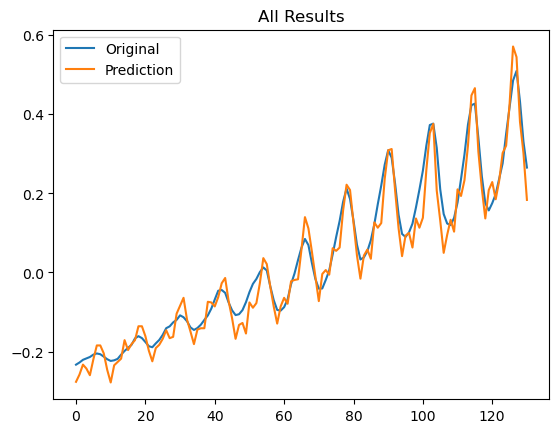

In [43]:
main()

## 1956 ~ 2008 오스트레일리아 맥주 판매량

In [12]:
df = pd.read_csv('ausbeer.csv', index_col=0)
df.head()

,time,value
1,1956.00,284
2,1956.25,213
3,1956.50,227
4,1956.75,308
5,1957.00,262


## GAN

In [13]:
class Data:
    def __init__(self, mu, sigma, ni_D):
        self.real_sample = lambda n_batch : np.random.normal(mu, sigma, (n_batch, ni_D))
        self.in_sample = lambda n_batch : np.random.rand(n_batch, ni_D)

In [14]:
def add_decorate(x):
    m = K.mean(x, axis=-1, keepdims=True)
    d = K.square(x - m)
    return K.concatenate([x, d], axis=-1)

def add_decorate_shape(input_shape):
    shape = list(input_shape)
    assert len(shape) == 2
    shape[1] *= 2
    return tuple(shape)

In [15]:
lr = 2e-4 # 0.00002
adam = Adam(lr=lr, beta_1=0.9, beta_2=0.999)

def model_compile(model):
    return model.compile(loss='binary_crossentropy', optimizer=adam, metrics=['accuracy'])

c:\ProgramData\anaconda3\envs\tf\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [24]:
class GAN:
    def __init__(self, ni_D, nh_D, nh_G):
        self.ni_D = ni_D
        self.nh_D = nh_D
        self.nh_G = nh_G
        
        self.D = self.gen_D()
        self.G = self.gen_G()
        self.GD = self.make_GD()
        
    def gen_D(self):
        ni_D = self.ni_D
        nh_D = self.nh_D
        D = Sequential()
        D.add(Lambda(add_decorate, output_shape=add_decorate_shape, input_shape=(ni_D,)))
        D.add(Dense(nh_D, activation='relu'))    
        D.add(Dense(nh_D, activation='relu'))    
        D.add(Dense(1, activation='sigmoid'))
        
        model_compile(D)
        return D    
    
    def gen_G(self):
        ni_D = self.ni_D
        #nh_D = self.nh_D 
        nh_G = self.nh_G
        
        G = Sequential()
        G.add(Reshape((ni_D, 1), input_shape=(ni_D,)))
        G.add(Conv1D(nh_G, 1, activation='relu'))    
        G.add(Conv1D(nh_G, 1, activation='sigmoid'))    
        G.add(Conv1D(1,1))
        G.add(Flatten())
        
        model_compile(G)
        return G    
    
    def make_GD(self):
        G, D = self.G, self.D
        GD = Sequential()
        GD.add(G)
        GD.add(D)
        D.trainable = False
        model_compile(GD)
        D.trainable = True
        return GD
    
    def D_train_on_batch(self, Real, Gen):
        D = self.D
        X = np.concatenate([Real, Gen], axis=0)
        y = np.array([1] * Real.shape[0] + [0] * Gen.shape[0])
        D.train_on_batch(X, y)

    def GD_train_on_batch(self, Z):
        GD = self.GD
        y = np.array([1] * Z.shape[0])
        GD.train_on_batch(Z, y)

In [34]:
class Machine:
    def __init__(self, n_batch=10, ni_D=100):
        data_mean = 4
        data_stddev = 1.25
        
        self.n_iter_D = 1
        self.n_iter_G = 5
        
        self.data = Data(data_mean, data_stddev, ni_D)
        self.gan = GAN(ni_D=ni_D, nh_D=50, nh_G=50)
        
        self.n_batch = n_batch
        
    def run(self, n_repeat=200, n_show=200, n_test=100):
        for ii in range(n_repeat):
            print(f"Stage {ii} Epoch : {n_show}")
            self.run_epochs(n_show, n_test)
            plt.show()
            
    def run_epochs(self, epochs, n_test):
        self.train(epochs)
        self.test_and_show(n_test)
        
    def train_each(self):
        for it in range(self.n_iter_D):
            self.train_D()
        for it in range(self.n_iter_G):
            self.train_GD()
            
    def train(self, epochs):
        for epoch in range(epochs):
            self.train_each()
            
    def test(self, n_test):
        gan = self.gan
        data = self.data
        Z = data.in_sample(n_test)
        Gen = gan.G.predict(Z)
        return Gen, Z
            
    def train_D(self):
        gan = self.gan
        n_batch = self.n_batch
        data = self.data
        
        Real = data.real_sample(n_batch)
        
        Z = data.in_sample(n_batch)
        Gen = gan.G.predict(Z)
        
        gan.D.trainable = True
        gan.D_train_on_batch(Real, Gen)
        
    def train_GD(self):
        gan = self.gan
        n_batch = self.n_batch
        data = self.data
        Z = data.in_sample(n_batch)
        
        gan.D.trainable = False
        gan.GD_train_on_batch(Z)
        
    def show_hist(self, Real, Gen, Z):
        plt.hist(Real.reshape(-1), histtype='step', label='Real')
        plt.hist(Gen.reshape(-1), histtype='step', label='Generated')
        plt.hist(Z.reshape(-1), histtype='step', label='Input')
        plt.legend(loc=0)
        
    def test_and_show(self, n_test):
        data = self.data
        Gen, Z = self.test(n_test)
        Real = data.real_sample(n_test)
        self.show_hist(Real, Gen, Z)
        Machine.print_stat(Real, Gen)
        
    @staticmethod
    def print_stat(Real, Gen):
        def stat(d):
            return (np.mean(d), np.std(d))
        print(F'Mean and Std of Real: {stat(Real)}')
        print(F'Mean and Std of Gen: {stat(Gen)}')
        

In [35]:
def main():
    machine = Machine(n_batch=1, ni_D=100)
    machine.run(n_repeat=200, n_show=200, n_test=100)

4/4 [==============================] - 0s 3ms/step
Mean and Std of Real: (3.995777646308662, 1.256568711377153)
Mean and Std of Gen: (3.995504, 1.2522854)


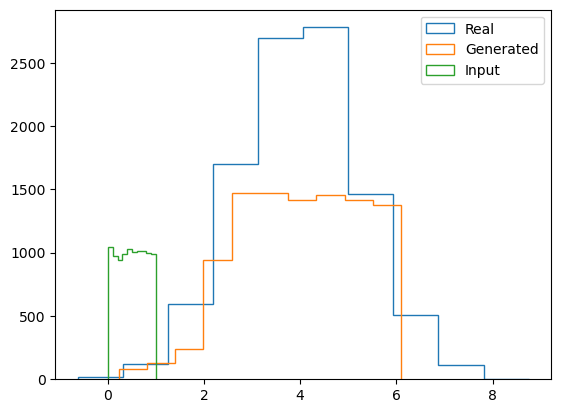

Stage 133 Epoch : 200
4/4 [==============================] - 0s 3ms/step
Mean and Std of Real: (3.999368281775633, 1.2382802122284866)
Mean and Std of Gen: (3.8500957, 1.2596171)


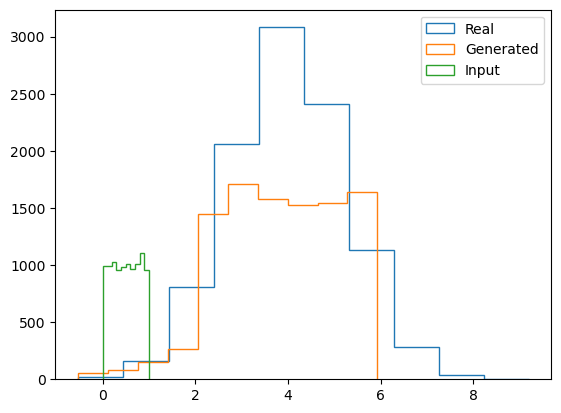

Stage 134 Epoch : 200
4/4 [==============================] - 0s 6ms/step
Mean and Std of Real: (4.013523393746256, 1.2516861749425066)
Mean and Std of Gen: (4.0231695, 1.1757972)


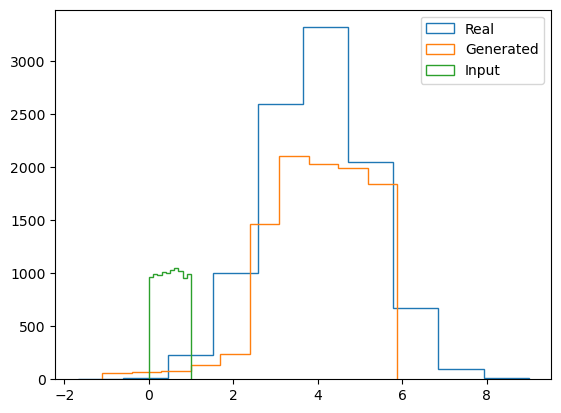

Stage 135 Epoch : 200
4/4 [==============================] - 0s 4ms/step
Mean and Std of Real: (4.004720273075218, 1.2467069187750348)
Mean and Std of Gen: (4.388241, 1.2458776)


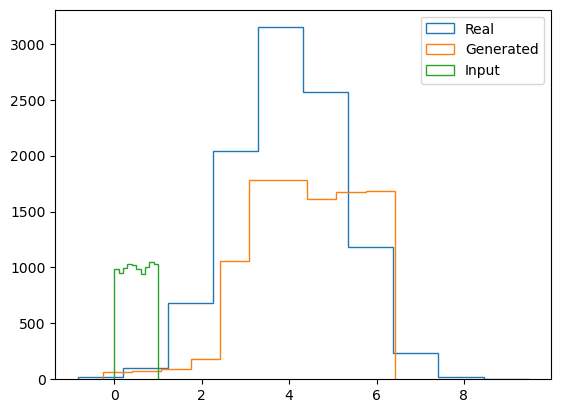

Stage 136 Epoch : 200
4/4 [==============================] - 0s 4ms/step
Mean and Std of Real: (4.011230806747337, 1.2553692094218651)
Mean and Std of Gen: (3.8575964, 1.2810348)


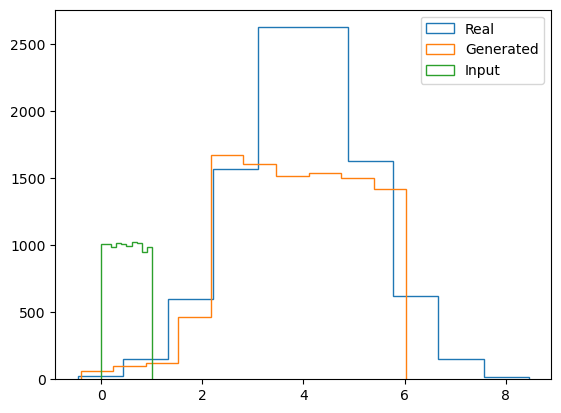

Stage 137 Epoch : 200
4/4 [==============================] - 0s 3ms/step
Mean and Std of Real: (4.001168857925957, 1.243174908591312)
Mean and Std of Gen: (4.02068, 1.231958)


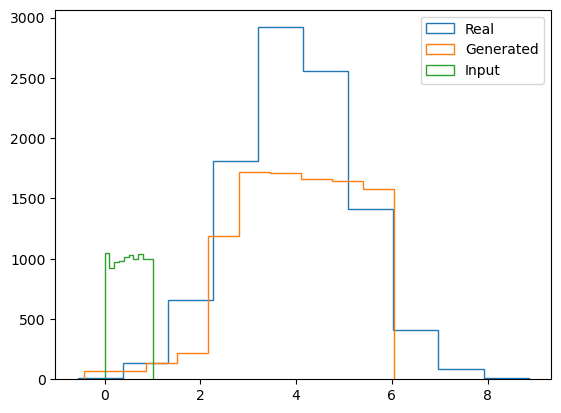

Stage 138 Epoch : 200
4/4 [==============================] - 0s 6ms/step
Mean and Std of Real: (3.991870998712576, 1.244828048742964)
Mean and Std of Gen: (4.188497, 1.2650889)


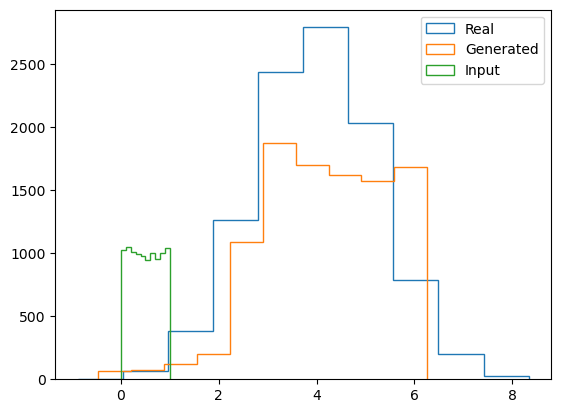

Stage 139 Epoch : 200
4/4 [==============================] - 0s 4ms/step
Mean and Std of Real: (4.025077718170139, 1.2591474227081214)
Mean and Std of Gen: (3.77545, 1.2296066)


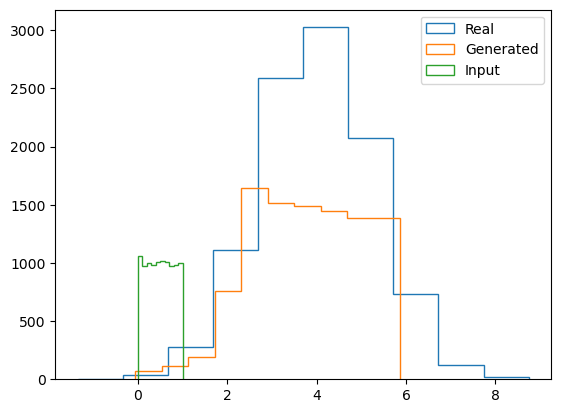

Stage 140 Epoch : 200
1/1 [==============================] - 0s 13ms/step


KeyboardInterrupt: 

In [36]:
main()